In [1]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import math

import time
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, zero_one_loss, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import callbacks
from keras import losses
from keras.models import save_model, load_model

2024-11-26 14:38:07.567561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 14:38:07.593357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# Dataset loading and visualization

In [5]:
colonne=pd.read_csv('./kddcup.names',sep=':',skiprows=1,header=None)

attacchi=pd.DataFrame(['attack_type'])

hn=pd.concat([colonne,attacchi],ignore_index=True)
header_names=hn.iloc[:,0].tolist()

print(header_names,'\n')

data = pd.read_csv('./data_no_dup.csv',names=header_names)

label=data['attack_type']
data=data.drop(['attack_type'],axis=1)


['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type'] 



In [6]:
print(data.describe,'\n')
print(label.shape,'\n')
print(label.describe,'\n')

<bound method NDFrame.describe of          duration protocol_type service flag  src_bytes  dst_bytes  land  \
0               0           tcp    http   SF        215      45076     0   
1               0           tcp    http   SF        162       4528     0   
2               0           tcp    http   SF        236       1228     0   
3               0           tcp    http   SF        233       2032     0   
4               0           tcp    http   SF        239        486     0   
...           ...           ...     ...  ...        ...        ...   ...   
1074987         0           tcp    http   SF        212       2288     0   
1074988         0           tcp    http   SF        219        236     0   
1074989         0           tcp    http   SF        218       3610     0   
1074990         0           tcp    http   SF        219       1234     0   
1074991         0           tcp    http   SF        219       1098     0   

         wrong_fragment  urgent  hot  ...  dst_host_c

In [7]:
col_names = np.array(header_names)
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

#print('Nominal: ',nominal_idx)
#for j in nominal_idx: print(header_names[j])
#print()

#print('Binary: ', binary_idx)
#for j in binary_idx: print(header_names[j])
#print()

#print('Numeric: ',numeric_idx)
#for j in numeric_idx: print(header_names[j])

nominal_column=col_names[nominal_idx].tolist()
binary_column=col_names[binary_idx].tolist()
numeric_column=col_names[numeric_idx].tolist()

#print('\nNumeric: ',pd.Series(numeric_column).count(), '\nBinary: ', pd.Series(binary_column).count(), '\nNominal: ',pd.Series(nominal_column).count())

attack_type
normal.             812814
neptune.            242149
satan.                5019
ipsweep.              3723
portsweep.            3564
smurf.                3007
nmap.                 1554
back.                  968
teardrop.              918
warezclient.           893
pod.                   206
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
land.                   19
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64


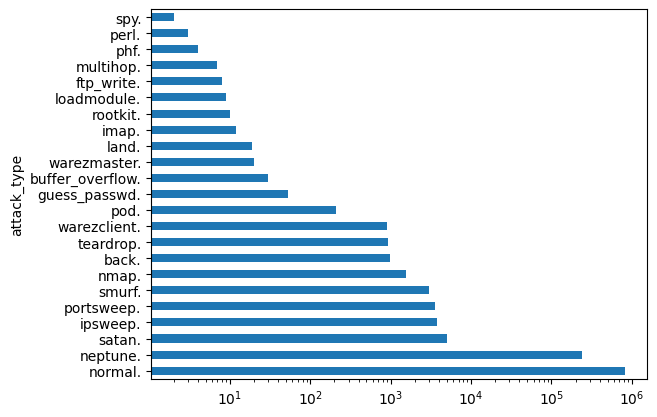

In [8]:
from collections import defaultdict
category = defaultdict(list)
category['benign'].append('normal.')
with open('./training_attack_types.txt', 'r') as ff:
    for line in ff.readlines():
        attack_name, attack_cat = line.strip().split(' ')
        category[attack_cat].append(attack_name)

#print(category)

attack_mapping = dict((a,c) for c in category for a in category[c])
#print('\nAttack mapping: ',attack_mapping,'\n')

attacchi=label.value_counts()
print(attacchi)
attacchi.plot(kind='barh')
plt.xscale('log')

attack_type
benign    812814
dos       247267
probe      13860
r2l          999
u2r           52
Name: count, dtype: int64


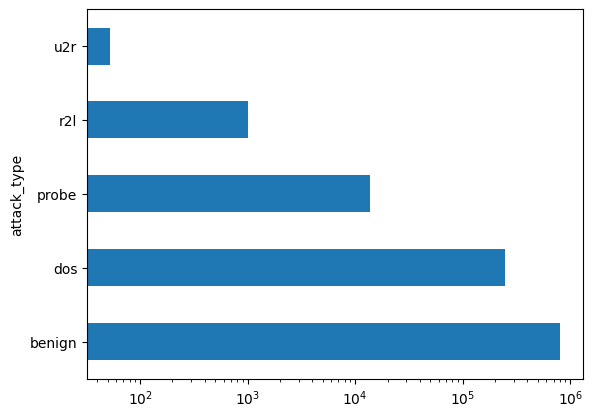

In [9]:
label_cat=label.map(lambda x: attack_mapping[x])
categorie_attacchi=label_cat.value_counts()
print(categorie_attacchi)
categorie_attacchi.plot(kind='barh')
plt.xscale('log')

# Data analysis and fixing

In [10]:
#data[binary_column].describe().transpose()


In [11]:
#data[nominal_column].describe().transpose()

In [12]:
#data['protocol_type'].unique()

In [13]:
#data[numeric_column].describe().transpose()

In [14]:
# In the category 'su_attempted' the maximum is 2 altough it is binary, we have to fix it
#data.groupby(['su_attempted']).size()


In [15]:
data['su_attempted'].replace(2,1,inplace=True)
#data.groupby(['su_attempted']).size()

/tmp/ipykernel_427/810226542.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['su_attempted'].replace(2,1,inplace=True)


In [16]:
# In the category 'su_attempted' the maximum count is 0, thus we can safely remove it
#data.groupby(['num_outbound_cmds']).size()


In [17]:
data.drop('num_outbound_cmds', axis=1, inplace=True)
ind=numeric_column.index('num_outbound_cmds')
numeric_column.remove('num_outbound_cmds')
numeric_idx.remove(ind)

In [18]:
print('Numeric: ',pd.Series(numeric_column).count(), '\nBinary: ', pd.Series(binary_column).count(), '\nNominal: ',pd.Series(nominal_column).count())

Numeric:  31 
Binary:  6 
Nominal:  3


# Data preparation

In [19]:
data_raw = pd.get_dummies(data, columns=nominal_column, drop_first=True)


In [20]:
data.shape

(1074992, 40)

In [21]:
data_raw.shape

(1074992, 118)

In [22]:
dummy_variables = list(set(data_raw) - set(data))
#print(dummy_variables)

# Create a binary classification dataset

In [23]:
label_cat_bin = label_cat.apply(lambda x: 'benign' if x == 'benign' else 'attack')

In [24]:
# split dataset -> train + test dataset
X_train, X_test, y_train, y_test = train_test_split(data_raw, label_cat_bin, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,X_train.shape[0]+X_test.shape[0],len(data_raw))

(859993, 118) (214999, 118) 1074992 1074992


In [25]:
ca=label_cat_bin.value_counts()
print(ca,'\n')
ca_train=y_train.value_counts()
print(ca_train,'\n')

attack_type
benign    812814
attack    262178
Name: count, dtype: int64 

attack_type
benign    650271
attack    209722
Name: count, dtype: int64 



In [26]:
X_train.insert(X_train.shape[1], 'label', y_train, True)
X_train.shape
X_train = X_train.drop(X_train[X_train.label == 'attack'].index)
y_train_b = X_train['label']
X_train=X_train.drop(['label'],axis=1)

In [27]:
X_train.shape

(650271, 118)

In [28]:
X_test.shape

(214999, 118)

In [29]:
y_train_b.shape

(650271,)

In [30]:
y_test.shape

(214999,)

In [31]:
# split train -> train_t + validation dataset
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train_b, test_size=0.2, random_state=42)


## Regularization of numeric features

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#train_data_std = X_train
#test_data_std = X_test

scaler = MinMaxScaler().fit(X_train_t[numeric_column])

#train_data_std.loc[:,numeric_column] = standard_scaler.transform(train_data_std[numeric_column])
#test_data_std.loc[:,numeric_column] = standard_scaler.transform(test_data_std[numeric_column])

X_train_t[numeric_column] = scaler.transform(X_train_t[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])
X_val[numeric_column] = scaler.transform(X_val[numeric_column])


In [33]:
X_train_t[binary_column].describe().transpose()


count      mean       std  min  25%  50%  75%  max
land            520216.0  0.000010  0.003100  0.0  0.0  0.0  0.0  1.0
logged_in       520216.0  0.831114  0.374651  0.0  1.0  1.0  1.0  1.0
root_shell      520216.0  0.000344  0.018546  0.0  0.0  0.0  0.0  1.0
su_attempted    520216.0  0.000148  0.012165  0.0  0.0  0.0  0.0  1.0
is_host_login   520216.0  0.000002  0.001386  0.0  0.0  0.0  0.0  1.0
is_guest_login  520216.0  0.004623  0.067836  0.0  0.0  0.0  0.0  1.0

In [34]:
X_train_t[dummy_variables].describe().transpose()

count unique    top    freq
flag_RSTOS0      520216      1  False  520216
service_discard  520216      1  False  520216
flag_RSTR        520216      2  False  519999
service_pm_dump  520216      1  False  520216
service_http     520216      2   True  369922
...                 ...    ...    ...     ...
flag_RSTO        520216      2  False  519835
service_private  520216      2  False  516433
service_pop_2    520216      1  False  520216
service_sql_net  520216      1  False  520216
flag_S1          520216      2  False  519881

[81 rows x 4 columns]

In [35]:
X_train_t[numeric_column].describe().transpose()

count      mean       std  min       25%  \
duration                     520216.0  0.002519  0.020235  0.0  0.000000   
src_bytes                    520216.0  0.000069  0.002879  0.0  0.000008   
dst_bytes                    520216.0  0.000722  0.006508  0.0  0.000056   
wrong_fragment               520216.0  0.000000  0.000000  0.0  0.000000   
urgent                       520216.0  0.000004  0.001547  0.0  0.000000   
hot                          520216.0  0.000768  0.013294  0.0  0.000000   
num_failed_logins            520216.0  0.000030  0.003619  0.0  0.000000   
num_compromised              520216.0  0.000007  0.001503  0.0  0.000000   
num_root                     520216.0  0.000011  0.001530  0.0  0.000000   
num_file_creations           520216.0  0.000156  0.006580  0.0  0.000000   
num_shells                   520216.0  0.000217  0.010465  0.0  0.000000   
num_access_files             520216.0  0.000638  0.009452  0.0  0.000000   
count                        520216.0  0.017923  0.037500  0.0  0.001957   
srv_count                    520216.0  0.024303  0.045785  0.0  0.003922   
serror_rate                  520216.0  0.001733  0.029225  0.0  0.000000   
srv_serror_rate              520216.0  0.002044  0.028542  0.0  0.000000   
rerror_rate                  520216.0  0.045796  0.208013  0.0  0.000000   
srv_rerror_rate              520216.0  0.046148  0.206483  0.0  0.000000   
same_srv_rate                520216.0  0.987878  0.084004  0.0  1.000000   
diff_srv_rate                520216.0  0.015649  0.109599  0.0  0.000000   
srv_diff_host_rate           520216.0  0.150958  0.289975  0.0  0.000000   
dst_host_count               520216.0  0.527429  0.395883  0.0  0.125490   
dst_host_srv_count           520216.0  0.806898  0.324630  0.0  0.674510   
dst_host_same_srv_rate       520216.0  0.862210  0.282110  0.0  0.940000   
dst_host_diff_srv_rate       520216.0  0.037055  0.129401  0.0  0.000000   
dst_host_same_src_port_rate  520216.0  0.109276  0.238188  0.0  0.000000   
dst_host_srv_diff_host_rate  520216.0  0.025738  0.049281  0.0  0.000000   
dst_host_serror_rate         520216.0  0.002507  0.032028  0.0  0.000000   
dst_host_srv_serror_rate     520216.0  0.001265  0.017100  0.0  0.000000   
dst_host_rerror_rate         520216.0  0.048205  0.203537  0.0  0.000000   
dst_host_srv_rerror_rate     520216.0  0.046788  0.198327  0.0  0.000000   

                                  50%       75%  max  
duration                     0.000000  0.000000  1.0  
src_bytes                    0.000010  0.000013  1.0  
dst_bytes                    0.000139  0.000496  1.0  
wrong_fragment               0.000000  0.000000  0.0  
urgent                       0.000000  0.000000  1.0  
hot                          0.000000  0.000000  1.0  
num_failed_logins            0.000000  0.000000  1.0  
num_compromised              0.000000  0.000000  1.0  
num_root                     0.000000  0.000000  1.0  
num_file_creations           0.000000  0.000000  1.0  
num_shells                   0.000000  0.000000  1.0  
num_access_files             0.000000  0.000000  1.0  
count                        0.007828  0.021526  1.0  
srv_count                    0.011765  0.029412  1.0  
serror_rate                  0.000000  0.000000  1.0  
srv_serror_rate              0.000000  0.000000  1.0  
rerror_rate                  0.000000  0.000000  1.0  
srv_rerror_rate              0.000000  0.000000  1.0  
same_srv_rate                1.000000  1.000000  1.0  
diff_srv_rate                0.000000  0.000000  1.0  
srv_diff_host_rate           0.000000  0.150000  1.0  
dst_host_count               0.466667  1.000000  1.0  
dst_host_srv_count           1.000000  1.000000  1.0  
dst_host_same_srv_rate       1.000000  1.000000  1.0  
dst_host_diff_srv_rate       0.000000  0.010000  1.0  
dst_host_same_src_port_rate  0.010000  0.060000  1.0  
dst_host_srv_diff_host_rate  0.010000  0.030000  1.0  
dst_host_serror_rate         0.000000  0.000000  1.0  
dst_

In [36]:
X_test[numeric_column].describe().transpose()

count          mean       std  min       25%  \
duration                     214999.0  2.351735e-03  0.023165  0.0  0.000000   
src_bytes                    214999.0  3.381638e-04  0.122157  0.0  0.000000   
dst_bytes                    214999.0  5.827033e-04  0.009546  0.0  0.000000   
wrong_fragment               214999.0  2.748850e-03  0.088433  0.0  0.000000   
urgent                       214999.0  9.966824e-07  0.000344  0.0  0.000000   
hot                          214999.0  6.784689e-04  0.012479  0.0  0.000000   
num_failed_logins            214999.0  3.720948e-05  0.004762  0.0  0.000000   
num_compromised              214999.0  3.008127e-06  0.000373  0.0  0.000000   
num_root                     214999.0  6.009545e-06  0.000418  0.0  0.000000   
num_file_creations           214999.0  1.344517e-04  0.006684  0.0  0.000000   
num_shells                   214999.0  1.651170e-04  0.009085  0.0  0.000000   
num_access_files             214999.0  4.692528e-04  0.007905  0.0  0.000000   
count                        214999.0  9.662849e-02  0.167137  0.0  0.003914   
srv_count                    214999.0  2.538780e-02  0.057706  0.0  0.003922   
serror_rate                  214999.0  1.896025e-01  0.390538  0.0  0.000000   
srv_serror_rate              214999.0  1.901929e-01  0.391169  0.0  0.000000   
rerror_rate                  214999.0  7.876353e-02  0.267961  0.0  0.000000   
srv_rerror_rate              214999.0  7.858906e-02  0.266995  0.0  0.000000   
same_srv_rate                214999.0  7.785404e-01  0.391683  0.0  1.000000   
diff_srv_rate                214999.0  3.170029e-02  0.117212  0.0  0.000000   
srv_diff_host_rate           214999.0  1.178375e-01  0.265424  0.0  0.000000   
dst_host_count               214999.0  6.353121e-01  0.400858  0.0  0.200000   
dst_host_srv_count           214999.0  6.237850e-01  0.431034  0.0  0.070588   
dst_host_same_srv_rate       214999.0  6.694876e-01  0.426052  0.0  0.070000   
dst_host_diff_srv_rate       214999.0  4.982921e-02  0.131777  0.0  0.000000   
dst_host_same_src_port_rate  214999.0  9.315076e-02  0.229472  0.0  0.000000   
dst_host_srv_diff_host_rate  214999.0  2.170401e-02  0.056832  0.0  0.000000   
dst_host_serror_rate         214999.0  1.901351e-01  0.390385  0.0  0.000000   
dst_host_srv_serror_rate     214999.0  1.896244e-01  0.390948  0.0  0.000000   
dst_host_rerror_rate         214999.0  7.992967e-02  0.262737  0.0  0.000000   
dst_host_srv_rerror_rate     214999.0  7.888730e-02  0.261826  0.0  0.000000   

                                  50%       75%        max  
duration                     0.000000  0.000000   0.732843  
src_bytes                    0.000009  0.000013  56.512410  
dst_bytes                    0.000065  0.000335   2.284787  
wrong_fragment               0.000000  0.000000   3.000000  
urgent                       0.000000  0.000000   0.142857  
hot                          0.000000  0.000000   0.389610  
num_failed_logins            0.000000  0.000000   1.250000  
num_compromised              0.000000  0.000000   0.083166  
num_root                     0.000000  0.000000   0.091591  
num_file_creations           0.000000  0.000000   0.930233  
num_shells                   0.000000  0.000000   0.500000  
num_access_files             0.000000  0.000000   0.555556  
count                        0.015656  0.066536   1.000000  
srv_count                    0.013725  0.029412   1.001961  
serror_rate                  0.000000  0.000000   1.000000  
srv_serror_rate              0.000000  0.000000   1.000000  
rerror_rate                  0.000000  0.000000   1.000000  
srv_rerror_rate              0.000000  0.000000   1.000000  
same_srv_rate                1.000000  1.000000   1.000000  
diff_srv_rate                0.000000  0.010000   1.000000  
srv_diff_host_rate           0.000000  0.090000   1.000000  
dst_host_count               0.878431  1.000000   1.000000  
dst_host_srv_count           0.972549  1.000000   1.000000  
dst_hos

In [37]:
print(X_train_t.shape,X_val.shape,X_train.shape)

(520216, 118) (130055, 118) (650271, 118)


In [38]:
#X_train_t=np.array(X_train_t)
#X_test=np.array(X_test)
#X_val=np.array(X_val)
#
#X_train_t = np.nan_to_num(X_train_t, nan=0.0, posinf=0.0, neginf=0.0)
#X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
#X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
#
#X_train_t = X_train_t.astype(np.float32)
#X_val = X_val.astype(np.float32)
#X_test = X_test.astype(np.float32)

##y_train_t = y_train_t.astype(np.float32)
##y_val = y_val.astype(np.float32)
##y_test = y_test.astype(np.float32)


## Define and run the DNN

In [39]:
X_test.insert(X_test.shape[1], 'label', y_test, True)
X_test.shape
X_test_b = X_test.drop(X_test[X_test.label == 'attack'].index)
X_test_a = X_test.drop(X_test[X_test.label == 'benign'].index)
X_test_a=X_test_a.drop(['label'],axis=1)
X_test_b=X_test_b.drop(['label'],axis=1)
X_test=X_test.drop(['label'],axis=1)

In [40]:
print(X_test.shape, X_test_a.shape,X_test_b.shape)

(214999, 118) (52456, 118) (162543, 118)


In [41]:
n_features = X_train.shape[1]

/opt/conda/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16257/16257 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/50
16257/16257 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/50
16257/16257 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/50
16257/16257 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/50
16257/16257 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/50
16257/16257 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/50
16257/16257 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - loss: 0.0013 - mean_squ

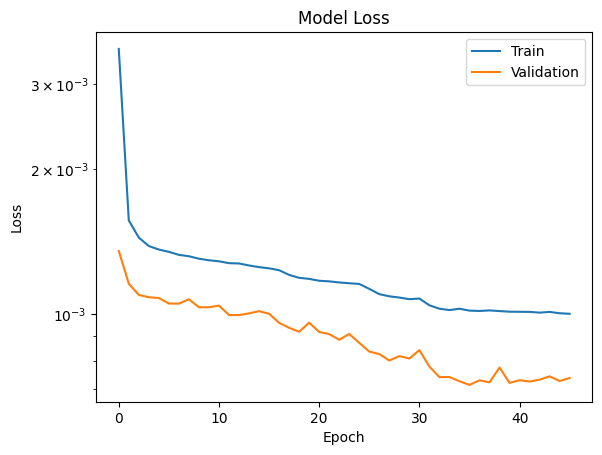

In [66]:
# model

n_features = X_train.shape[1]

encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation='relu', input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=10, activation='relu'))
encoder.add(layer=layers.Dense(units=5, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=10, activation='relu', input_shape=[5]))
decoder.add(layer=layers.Dense(units=20, activation='relu'))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss='MSE', optimizer='adam', metrics=['mean_squared_error'])

# train model

es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, restore_best_weights=True)
history = autoencoder.fit(x=X_train_t, y=X_train_t, epochs=50, verbose=1, validation_data=[X_val, X_val], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [43]:
#autoencoder.summary()
#models.save_model(autoencoder, '/content/drive/MyDrive/Colab Notebooks/model_2023')

In [44]:
#autoencoder=models.load_model('/content/drive/MyDrive/Colab Notebooks/model_2023')
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 5)              │         2,645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 118)            │         2,758 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,211 (63.33 KB)

 Trainable params: 5,403 (21.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,808 (42.22 KB)

In [45]:
X_train_predicted = autoencoder.predict(x=X_train_t)

train_events_mse = losses.mean_squared_error(X_train_t, X_train_predicted)
cut_off = np.percentile(train_events_mse, 99)
print('Threshold (99 pctile): ',cut_off)

16257/16257 ━━━━━━━━━━━━━━━━━━━━ 6s 391us/step
Threshold (99 pctile):  0.012156682927161454


In [46]:
cut_off_95 = np.percentile(train_events_mse, 95)
print('Threshold (95 pctile): ',cut_off_95)

Threshold (95 pctile):  0.004144242382608354


In [47]:
print(train_events_mse.shape,'\n')

(520216,) 



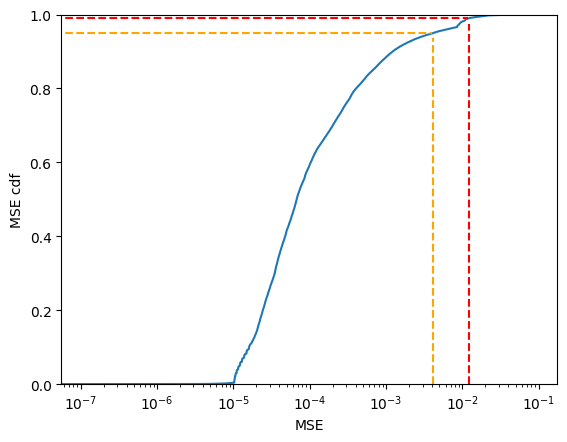

In [48]:
#models.load_model('/content/drive/MyDrive/Colab Notebooks/model_2023')
ax=sns.ecdfplot(data=train_events_mse)
ax.set(xscale="log")
ax.set_xlabel('MSE')
ax.set_ylabel('MSE cdf')

n_points=40
line_h1 = Line2D(xdata=np.arange(0, cut_off,cut_off/n_points),ydata=np.full(n_points, 0.99),color='red',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_h1)
line_v1 = Line2D(xdata=np.full(n_points,cut_off),ydata=np.arange(0, 0.99, 1/n_points),color='red',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_v1)

line_h2 = Line2D(xdata=np.arange(0, cut_off_95,cut_off_95/n_points),ydata=np.full(n_points, 0.95),color='orange',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_h2)
line_v2 = Line2D(xdata=np.full(n_points,cut_off_95),ydata=np.arange(0, 0.95, 0.96/n_points),color='orange',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_v2)

(100, 118)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(100, 118)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


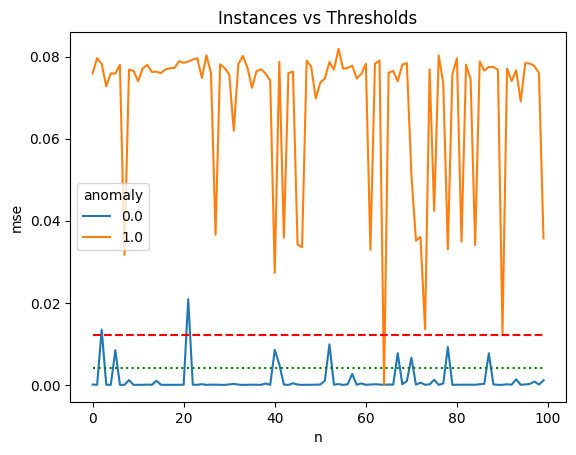

In [49]:
plot_samples = 100
# normal event
real_x = X_test_b[:plot_samples].to_numpy().reshape(plot_samples, n_features)
real_x = real_x.astype(np.float32)
real_x = np.nan_to_num(real_x)

print(real_x.shape)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({'mse': normal_events_mse, 'n': np.arange(0, plot_samples), 'anomaly': np.zeros(plot_samples)})

# abnormal event
#abnormal_x = scaler.transform(abnormal_events)[:plot_samples].reshape(plot_samples, n_features)
abnormal_x = X_test_a[:plot_samples].to_numpy().reshape(plot_samples, n_features)
abnormal_x = abnormal_x.astype(np.float32)
abnormal_x = np.nan_to_num(abnormal_x)
print(abnormal_x.shape)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = losses.mean_squared_error(abnormal_x, predicted_x)

abnormal_events_df = pd.DataFrame({'mse': abnormal_events_mse, 'n': np.arange(0, plot_samples), 'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
mse_df = mse_df.reset_index()
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(xdata=np.arange(0, plot_samples),ydata=np.full(plot_samples, cut_off),color='red',linewidth=1.5,linestyle='dashed')
line2 = Line2D(xdata=np.arange(0, plot_samples),ydata=np.full(plot_samples, cut_off_95),color='green',linewidth=1.5,linestyle='dotted')

plot.add_artist(line)
plot.add_artist(line2)
#plt.title('Threshold: {threshold}'.format(threshold=cut_off))
plt.title('Instances vs Thresholds')
plt.show()

In [50]:
X_test_b.shape

(162543, 118)

In [51]:
X_test_a.shape

(52456, 118)

# Build the Confusion Matrix

In [52]:
samples_b = X_test_b.shape[0]
# normal event
real_x_b = X_test_b.to_numpy().reshape(samples_b, n_features)
real_x_b = real_x_b.astype(np.float32)
real_x_b = np.nan_to_num(real_x_b)
t_0=time.monotonic()
predicted_x_b = autoencoder.predict(x=real_x_b)
normal_events_mse_ext = losses.mean_squared_error(real_x_b, predicted_x_b)
t_1=time.monotonic()
normal_events_df_ext = pd.DataFrame({'mse': normal_events_mse_ext})

# abnormal event
samples_a = X_test_a.shape[0]
t_2=time.monotonic()
abnormal_x_a = X_test_a.to_numpy().reshape(samples_a, n_features)
abnormal_x_a = abnormal_x_a.astype(np.float32)
abnormal_x_a = np.nan_to_num(abnormal_x_a)
predicted_x_a = autoencoder.predict(x=abnormal_x_a)
abnormal_events_mse_ext = losses.mean_squared_error(abnormal_x_a, predicted_x_a)
t_3=time.monotonic()
abnormal_events_df_ext = pd.DataFrame({'mse': abnormal_events_mse_ext})

print('Normal instance: ',(t_1-t_0)/samples_b*1e6,' us per sample\n')
print('Anomaly instance: ',(t_3-t_2)/samples_a*1e6,' us per sample\n')

5080/5080 ━━━━━━━━━━━━━━━━━━━━ 2s 375us/step
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step
Normal instance:  16.954927947336788  us per sample

Anomaly instance:  21.313713805683825  us per sample



In [53]:
# value_counts conta i valori distinti, quindi se ce ne sono alcuni uguali questa soluzione non
# li conta, è meglio fare la somma dei counts, in questo modo conta tutto
count_fn = (abnormal_events_df_ext[abnormal_events_df_ext.mse <= cut_off].value_counts()).sum()
#print(count_fn.sort_values)
print(count_fn)

505


In [54]:
#count_fnnn = len(abnormal_events_df_ext[abnormal_events_df_ext.mse <= cut_off].value_counts())
#print(count_fnnn)

In [55]:
#count_fp = len(normal_events_df_ext[normal_events_df_ext.mse > cut_off].value_counts())
#print(count_fp)

In [56]:
count_fp = (normal_events_df_ext[normal_events_df_ext.mse > cut_off].value_counts()).sum()
print(count_fp)

1618


In [57]:
tp = samples_a - count_fn

In [58]:
tn = samples_b - count_fp

In [59]:
#conf_mat = [[tp/samples_a, count_fn/samples_a],[count_fp/samples_b , tn/samples_b]]
conf_mat = [[tp, count_fn],[count_fp, tn]]

In [60]:
conf_mat = np.array(conf_mat)

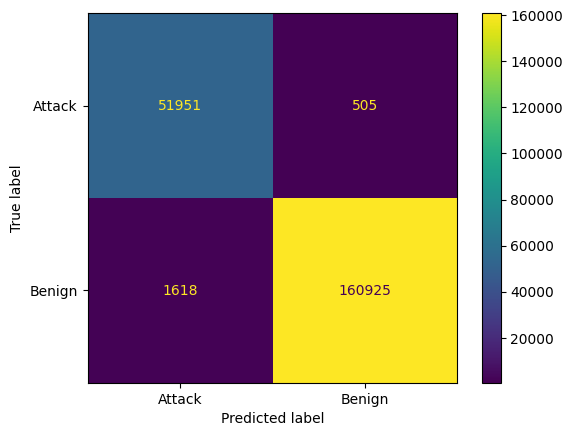

In [61]:
labels_cm = ['Attack' , 'Benign']
disp_cm = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels_cm)
disp_cm.plot()
plt.show()

In [62]:
precision_attack=(tp)/(tp+count_fp)
print('Precision (attack): ',precision_attack)

precision_benign=(tn)/(tn+count_fn)
print('Precision (benign): ',precision_benign)

Precision (attack):  0.9697959640837052
Precision (benign):  0.9968717090999195


In [63]:
recall_attack=(tp)/(tp+count_fn)
print('Recall (attack): ',recall_attack)
recall_benign=(tn)/(tn+count_fp)
print('Recall (benign): ',recall_benign)

Recall (attack):  0.9903728839408266
Recall (benign):  0.9900457109810943


In [67]:
real_xx = X_test.to_numpy().reshape((samples_a+samples_b), n_features)
real_xx = real_xx.astype(np.float32)
real_xx = np.nan_to_num(real_xx)
# 4. Fai delle predizioni sul test set
predictions = autoencoder.predict(x=real_xx)

# 5. Calcola l'errore di ricostruzione (MSE) per il test set
# mse_test = np.mean(np.square(X_test - predictions), axis=1)
mse_tester=losses.mean_squared_error(real_xx, predictions).numpy()
mse_test_dff=pd.DataFrame({'mse': mse_tester})
# 6. Applica la soglia per determinare le anomalie
# threshold = 0.010797960832714944

y_pred = (mse_test_dff.mse > cut_off_95).astype(int)  # 1 per anomalia, 0 per normale

import numpy as np



y_true = y_test.apply(lambda x: 0 if x == 'benign' else 1)
y_true = np.array(y_true)

y_pred = np.array(y_pred)

# Stampare i primi 10 valori di y_true e y_pred
print("Primi 10 valori di y_true:", y_true[:10])
print("Primi 10 valori di y_pred:", y_pred[:10])


print("Dimensioni di y_true:", y_true.shape)
print("Dimensioni di y_pred:", y_pred.shape)

# 7. Calcola le metriche di performance
accuracy = accuracy_score(y_true, y_pred)

# Precision e Recall separati per ciascuna classe (0=benigno, 1=maligno)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# 8. Matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)

# 9. Stampa i risultati
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision Benigni (0): {precision[0]:.4f}")
print(f"Precision Maligni (1): {precision[1]:.4f}")
print(f"Recall Benigni (0): {recall[0]:.4f}")
print(f"Recall Maligni (1): {recall[1]:.4f}")
print("Matrice di Confusione:")
print(conf_matrix)

6719/6719 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step
Primi 10 valori di y_true: [1 1 0 0 0 0 0 1 1 0]
Primi 10 valori di y_pred: [1 1 0 0 1 0 0 1 1 1]
Dimensioni di y_true: (214999,)
Dimensioni di y_pred: (214999,)
Accuracy: 0.9643
Precision Benigni (0): 0.9977
Precision Maligni (1): 0.8767
Recall Benigni (0): 0.9549
Recall Maligni (1): 0.9932
Matrice di Confusione:
[[155213   7330]
 [   356  52100]]


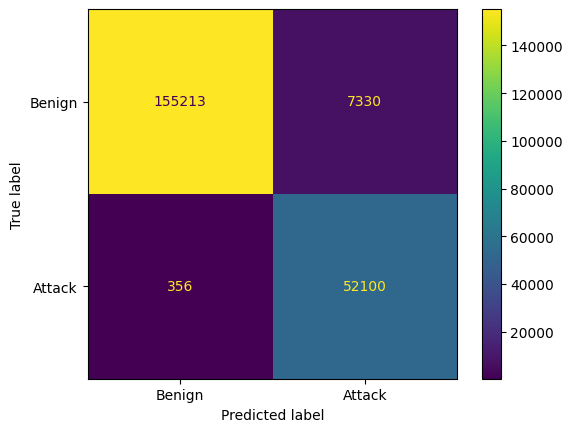

In [68]:
labels_cm2 = ['Benign' , 'Attack']
disp_cm2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_cm2)
disp_cm2.plot()
plt.show()